<a href="https://colab.research.google.com/github/Carlos-e-h/cv/blob/main/Notebook_2_LangGraph_Multi_Agent_System_Austin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Agent Workflows + RAG - LangGraph

Today we'll be looking at an example of a Multi-Agent workflow that's powered by LangGraph, LCEL, and more!

We're going to be, more specifically, looking at a "heirarchical agent teams" from the [AutoGen: Enabling Next-Gen LLM
Applications via Multi-Agent Conversation](https://arxiv.org/pdf/2308.08155) paper.

This will be the final "graph" of our system:

![image](https://i.imgur.com/pWlM3Zk.png)

It's important to keep in mind that the actual implementation will be constructed of 3 separate graphs, the final one having 2 graphs as nodes! LangGraph is a heckuva tool!



## Dependencies

We'll start, as we normally do, by grabbing our dependencies.

We'll be using LangChain and LangGraph to power our application, so let's start by grabbing those!

In [ ]:
!pip install -qU langgraph==0.2.32 langchain==0.2.14 langchain_openai==0.1.23 langchain_core==0.2.39 langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.8/997.8 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.6/396.6 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.5 MB/s eta 0:00:00


We're going to be showing a simple RAG chain as part of our LangGraph - and so we'll need specific dependencies for that as well!

In [ ]:
!pip install -qU --disable-pip-version-check qdrant-client pymupdf tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.2/267.2 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 93.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.6/316.6 kB 27.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-datastore 2.19.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.28.3 which is incompatible.
google-cloud-firestore 2.16.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5

Since we'll be relying on OpenAI's suite of models to power our agents today, we'll want to provide our OpenAI API Key.

We're also going to be using the Tavily search tool - so we'll want to provide that API key as well!

Instruction for how to obtain the Tavily API key can be found:

1. [Tavily API Key](https://app.tavily.com/sign-in)



In [ ]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")
os.environ["TAVILY_API_KEY"] = getpass.getpass("TAVILY_API_KEY")

OpenAI API Key:··········
TAVILY_API_KEY··········


## Helper Functions for Agent Graphs

We'll be using a number of agents, nodes, and supervisors in the rest of the notebook - and so it will help to have a collection of useful helper functions that we can leverage to make our lives easier going forward.

Let's start with the most simple one!

#### Import Wall

Here's a wall of imports we'll be needing going forward!

In [ ]:
from typing import Any, Callable, List, Optional, TypedDict, Union

from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.runnables import Runnable
from langchain_core.tools import BaseTool
from langchain_openai import ChatOpenAI

from langgraph.graph import END, StateGraph

### Agent Node Helper

Since we're going to be wrapping each of our agents into a node - it will help to have an easy way to create the node!

In [ ]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

### Agent Creation Helper Function

Since we know we'll need to create agents to populate our agent nodes, let's use a helper function for that as well!

Notice a few things:

1. We have a standard suffix to append to our system messages for each agent to handle the tool calling and boilerplate prompting.
2. Each agent has its our scratchpad.
3. We're relying on OpenAI's function-calling API for tool selection
4. Each agent is its own executor.

In [ ]:
def create_agent(
    llm: ChatOpenAI,
    tools: list,
    system_prompt: str,
) -> str:
    """Create a function-calling agent and add it to the graph."""
    system_prompt += ("\nWork autonomously according to your specialty, using the tools available to you."
    " Do not ask for clarification."
    " Your other team members (and other teams) will collaborate with you with their own specialties."
    " You are chosen for a reason! You are one of the following team members: {team_members}.")
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_functions_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

### Supervisor Helper Function

Finally, we need a "supervisor" that decides and routes tasks to specific agents.

Since each "team" will have a collection of potential agents - this "supervisor" will act as an "intelligent" router to make sure that the right agent is selected for the right task.

Notice that, at the end of the day, this "supervisor" is simply directing who acts next - or if the state is considered "done".

In [ ]:
def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

## Weather Research Team - A LangGraph for Researching A Specific Topic

Now that we have our RAG chain set-up and some awesome helper functions, we want to create a LangGraph related to weather research for a weather report!

We're going to start by equipping our Research Team with a few tools:

1. Tavily Search - aka "Google", for the most up to date information possible.
2. The Weather tool

Let's create those tools now!

### Tool Creation

As you can see below, some tools already come pre-packaged ready to use!

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

Creating a custom tool, however, is very straightforward.

> NOTE: You *must* include a docstring, as that is what the LLM will consider when deciding when to use this tool.

In [ ]:
import requests
from langchain_core.tools import tool
from pydantic import BaseModel, Field
from langchain_core.tools import StructuredTool

class WeatherToolInput(BaseModel):
    latitude: float = Field(description="Latitude of the location")
    longitude: float = Field(description="Longitude of the location")

def get_weather(latitude: float, longitude: float) -> str:
    """Get the current weather for a given location's latitude and longitude"""
    response = requests.get(f"https://api.open-meteo.com/v1/forecast?latitude={latitude}&longitude={longitude}&current_weather=true")
    payload = response.json()

    weather_codes = {
      0: "Clear sky",
      1: "Mainly clear",
      2: "Partly cloudy",
      3: "Overcast",
      45: "Fog",
      48: "Depositing rime fog",
      51: "Drizzle: Light intensity",
      53: "Drizzle: Moderate intensity",
      55: "Drizzle: Dense intensity",
      56: "Freezing Drizzle: Light intensity",
      57: "Freezing Drizzle: Dense intensity",
      61: "Rain: Slight intensity",
      63: "Rain: Moderate intensity",
      65: "Rain: Heavy intensity",
      66: "Freezing Rain: Light intensity",
      67: "Freezing Rain: Heavy intensity",
      71: "Snow fall: Slight intensity",
      73: "Snow fall: Moderate intensity",
      75: "Snow fall: Heavy intensity",
      77: "Snow grains",
      80: "Rain showers: Slight intensity",
      81: "Rain showers: Moderate intensity",
      82: "Rain showers: Violent intensity",
      85: "Snow showers: Slight intensity",
      86: "Snow showers: Heavy intensity",
      95: "Thunderstorm: Slight or moderate",
      96: "Thunderstorm with slight hail",
      99: "Thunderstorm with heavy hail"
    }

    current = payload['current_weather']
    units = payload['current_weather_units']

    return (
      f"Temperature: {current['temperature']}{units['temperature']} "
      f"Wind Speed: {current['windspeed']} {units['windspeed']} "
      f"Wind Direction: {current['winddirection']}{units['winddirection']} "
      f"Conditions: {weather_codes[current['weathercode']]}"
    )


weather_tool = StructuredTool.from_function(
    func=get_weather,
    name="WeatherTool",
    args_schema=WeatherToolInput,
    description="Get the current weather for a given location's latitude and longitude"
)

> NOTE: We could just as easily use the LCEL chain directly, since nodes can be LCEL objects - but creating a tool helps explain the tool creation process at the same time.

### Research Team State

Since we're using LangGraph - we're going to need state!

Let's look at how we've created our state below.

In [ ]:
import functools
import operator
from typing import Annotated, List, Tuple, Union

from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
import functools

class ResearchTeamState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: List[str]
    next: str

Notice how we've used `messages`, `team_members`, and `next`.

These states will help us understand:

1. What we've done so far (`messages`)
2. Which team members we have access to (`team_members`)
3. Which team member is up next! (`next`)

### Research Team LLM

We'll be using `gpt-4-turbo` today. This LLM is going to be doing a lot of reasoning - and so using a "powerful" LLM is very important here!

In [ ]:
llm = ChatOpenAI(model="gpt-4-turbo")

### Research Team Agents & Nodes

Now we can use our helper functions to create our agent nodes, with their related tools.

Let's start with our search agent node.

#### Research Team: Search Agent

We're going to give our agent access to the Tavily tool, power it with our GPT-4 Turbo model, and then create its node - and name it `Search`.

In [ ]:
search_agent = create_agent(
    llm,
    [tavily_tool],
    "You are a research assistant who can search for up-to-date info using the tavily search engine.",
)
search_node = functools.partial(agent_node, agent=search_agent, name="Search")

#### Research Team: RAG Agent Node

Now we can wrap our LCEL RAG pipeline in an agent node as well, using the LCEL RAG pipeline as the tool, as created above.

In [ ]:
research_agent = create_agent(
    llm,
    [weather_tool],
    "You can retriever accurate weather information based on latitude and longitude",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Weather")

### Research Team Supervisor Agent

Notice that we're not yet creating our supervisor *node*, simply the agent here.

Also notice how we need to provide a few extra pieces of information - including which tools we're using.

> NOTE: It's important to use the *exact* tool name, as that is how the LLM will reference the tool. Also, it's important that your tool name is all a single alphanumeric string!



In [ ]:
supervisor_agent = create_team_supervisor(
    llm,
    ("You are a supervisor tasked with managing a conversation between the"
    " following workers:  Search, Weather. Given the following user request,"
    " determine the subject to be researched and respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. "
    " You should never ask your team to do anything beyond research. They are not required to write content or posts."
    " You should only pass tasks to workers that are specifically research focused."
    " When finished, respond with FINISH."),
    ["Search", "Weather"],
)

### Research Team Graph Creation

Now that we have our research team agent nodes created, and our supervisor agent - let's finally construct our graph!

We'll start by creating our base graph from our state, and then adding the nodes/agent we've created as nodes on our LangGraph.

In [ ]:
research_graph = StateGraph(ResearchTeamState)

research_graph.add_node("Search", search_node)
research_graph.add_node("Weather", research_node)
research_graph.add_node("supervisor", supervisor_agent)

Now we can define our edges - include our conditional edge from our supervisor to our agent nodes.

Notice how we're always routing our agent nodes back to our supervisor!

In [ ]:
research_graph.add_edge("Search", "supervisor")
research_graph.add_edge("Weather", "supervisor")
research_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"Search": "Search", "Weather": "Weather", "FINISH": END},
)

Now we can set our supervisor node as the entry point, and compile our graph!

In [ ]:
research_graph.set_entry_point("supervisor")
chain = research_graph.compile()

#### Display Graph

In [ ]:
!pip install -qU python_mermaid

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 3.9 MB/s eta 0:00:00


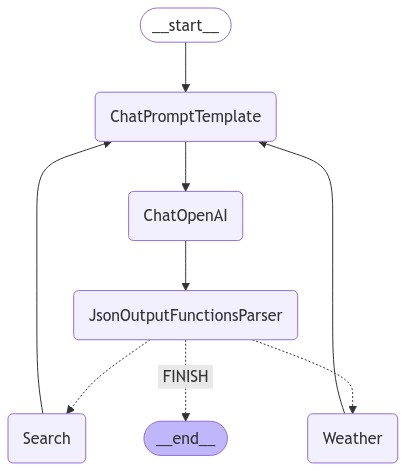

In [ ]:
from IPython.display import Image, display

try:
    display(Image(chain.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

The next part is key - since we need to "wrap" our LangGraph in order for it to be compatible in the following steps - let's create an LCEL chain out of it!

This allows us to "broadcast" messages down to our Research Team LangGraph!

In [ ]:
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ["Search", "Weather"],
    }
    return results

research_chain = enter_chain | chain

Now, finally, we can take it for a spin!

In [ ]:
for s in research_chain.stream(
    "Get details about Toronto weather today, and explain the weather status in technical terms", {"recursion_limit": 100}
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'Weather'}}
---
{'Weather': {'messages': [HumanMessage(content="Today's weather in Toronto features a clear sky, indicating no significant cloud coverage and no precipitation. The temperature is currently 10.8°C, which is relatively cool. The wind speed is at 20.3 km/h, coming from the west (276°). This wind speed is moderate and might cause a slight chill given the current temperature. Overall, the weather conditions are quite clear and may require light to moderate clothing due to the cool temperature and breeze.", name='Weather')]}}
---
{'supervisor': {'next': 'FINISH'}}
---


## Weather Report Writing Team - A LangGraph for Writing, Editing, and Planning a Meterological report.

Let's run it all back, this time specifically creating tools, agent nodes, and a graph for planning, writing, and editing a Meterological report!

### Tool Creation

Let's create some tools that will help us understand, open, work with, and edit documents to our liking!

In [ ]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional
from typing_extensions import TypedDict
import uuid
import os

os.makedirs('/content/data', exist_ok=True)

def create_random_subdirectory():
    random_id = str(uuid.uuid4())[:8]  # Use first 8 characters of a UUID
    subdirectory_path = os.path.join('/content/data', random_id)
    os.makedirs(subdirectory_path, exist_ok=True)
    return subdirectory_path

WORKING_DIRECTORY = Path(create_random_subdirectory())

@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to save the document."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ] = {},
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"

### Document Writing State

Just like with our Research Team state - we want to keep track of a few things, however this time - we also want to keep track of which files we've created - so let's add that here!

In [ ]:
import operator
from pathlib import Path

class DocWritingState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: str
    next: str
    current_files: str

### Document Writing Prelude Function

Since we have a working directory - we want to be clear about what our current working directory looks like - this helper function will allow us to do that cleanly!

In [ ]:
def prelude(state):
    written_files = []
    if not WORKING_DIRECTORY.exists():
        WORKING_DIRECTORY.mkdir()
    try:
        written_files = [
            f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")
        ]
    except:
        pass
    if not written_files:
        return {**state, "current_files": "No files written."}
    return {
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"
        + "\n".join([f" - {f}" for f in written_files]),
    }

### Document Writing Node Creation



In [ ]:
doc_writer_agent = create_agent(
    llm,
    [write_document, edit_document, read_document],
    ("You are an expert writing technical meteorological reports.\n"
    "Below are files currently in your directory:\n{current_files}"),
)
context_aware_doc_writer_agent = prelude | doc_writer_agent
doc_writing_node = functools.partial(
    agent_node, agent=context_aware_doc_writer_agent, name="DocWriter"
)

note_taking_agent = create_agent(
    llm,
    [create_outline, read_document],
    ("You are an expert senior researcher tasked with writing a meteorological reports outline and"
    " taking notes to craft a meteorological reports.\n{current_files}"),
)
context_aware_note_taking_agent = prelude | note_taking_agent
note_taking_node = functools.partial(
    agent_node, agent=context_aware_note_taking_agent, name="NoteTaker"
)

copy_editor_agent = create_agent(
    llm,
    [write_document, edit_document, read_document],
    ("You are an expert copy editor who focuses on fixing grammar, spelling, and tone issues\n"
    "Below are files currently in your directory:\n{current_files}"),
)
context_aware_copy_editor_agent = prelude | copy_editor_agent
copy_editing_node = functools.partial(
    agent_node, agent=context_aware_copy_editor_agent, name="CopyEditor"
)

dopeness_editor_agent = create_agent(
    llm,
    [write_document, edit_document, read_document],
    ("You are an expert in dopeness, litness, coolness, etc - you edit the document to make sure it's dope. Make sure to use a number of emojis - and make sure you write the edits to a new file with `_dopeness_edit` in the name."
    "Below are files currently in your directory:\n{current_files}"),
)
context_aware_dopeness_editor_agent = prelude | dopeness_editor_agent
dopeness_node = functools.partial(
    agent_node, agent=context_aware_dopeness_editor_agent, name="DopenessEditor"
)

doc_writing_supervisor = create_team_supervisor(
    llm,
    ("You are a supervisor tasked with managing a conversation between the"
    " following workers: {team_members}. You should always verify the technical"
    " contents after any edits are made. "
    "Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When each team is finished,"
    " you must respond with FINISH."),
    ["DocWriter", "NoteTaker", "DopenessEditor", "CopyEditor"],
)

### Document Writing Team LangGraph Construction

This part is almost exactly the same (with a few extra nodes) as our Research Team LangGraph construction - so we'll leave it as one block!

In [ ]:
authoring_graph = StateGraph(DocWritingState)
authoring_graph.add_node("DocWriter", doc_writing_node)
authoring_graph.add_node("NoteTaker", note_taking_node)
authoring_graph.add_node("CopyEditor", copy_editing_node)
authoring_graph.add_node("DopenessEditor", dopeness_node)
authoring_graph.add_node("supervisor", doc_writing_supervisor)

authoring_graph.add_edge("DocWriter", "supervisor")
authoring_graph.add_edge("NoteTaker", "supervisor")
authoring_graph.add_edge("CopyEditor", "supervisor")
authoring_graph.add_edge("DopenessEditor", "supervisor")

authoring_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "DocWriter": "DocWriter",
        "NoteTaker": "NoteTaker",
        "CopyEditor" : "CopyEditor",
        "DopenessEditor" : "DopenessEditor",
        "FINISH": END,
    },
)

authoring_graph.set_entry_point("supervisor")
chain = authoring_graph.compile()

#### Display Graph

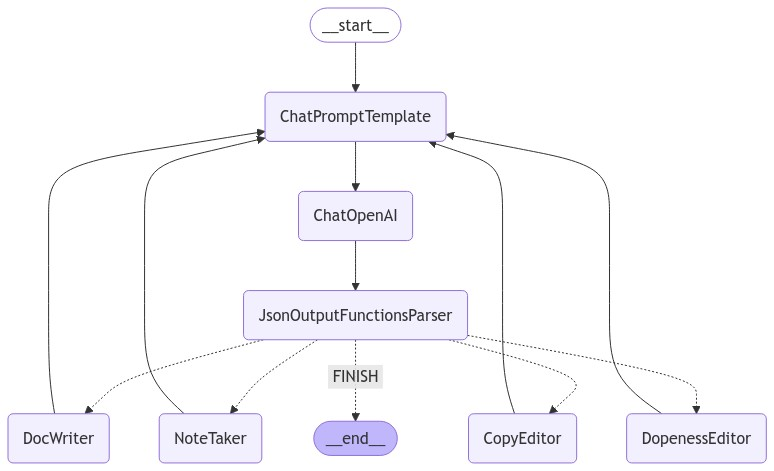

In [ ]:
from IPython.display import Image, display

try:
    display(Image(chain.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

Just as before - we'll need to create an "interface" between the level above, and our graph.

In [ ]:
def enter_chain(message: str, members: List[str]):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ", ".join(members),
    }
    return results

authoring_chain = (
    functools.partial(enter_chain, members=authoring_graph.nodes)
    | authoring_graph.compile()
)

Now we can test this out!

> NOTE: It is possible you may see an error here - rerun the cell to clear.

In [ ]:
for s in authoring_chain.stream(
    "Given the weather is, Temperature: 20.4°C Wind Speed: 21.1 km/h Wind Direction: 207° Conditions: Mainly clear, please create a weather report with your team.",
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'DocWriter'}}
---
{'DocWriter': {'messages': [HumanMessage(content='The weather report has been successfully created and saved to the file named "weather_report.txt". The team can now proceed with their respective tasks on the document.', name='DocWriter')]}}
---
{'supervisor': {'next': 'NoteTaker'}}
---
{'NoteTaker': {'messages': [HumanMessage(content='The weather report outline has been saved successfully. Now, I am going to take some notes for the report.\n\n1. Introduction: Briefly introduce the weather conditions for the day.\n2. Temperature: The temperature is 20.4°C.\n3. Wind Speed: The wind speed is 21.1 km/h.\n4. Wind Direction: The wind direction is 207°.\n5. Conditions: The conditions are mainly clear. \n\nWe can elaborate on these points while writing the detailed report.', name='NoteTaker')]}}
---
{'supervisor': {'next': 'CopyEditor'}}
---
{'CopyEditor': {'messages': [HumanMessage(content='The document, "weather_report.txt," has been reviewed and no

## Task 5: Meta-Supervisor and Full Graph

Finally, now that we have our two LangGraph agents (some of which are already multi-agent), we can build a supervisor that sits above all of them!

The final process, surprisingly, is quite straight forward!

Let's jump in!

First off - we'll need to create our supervisor agent node.

In [ ]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI

llm = ChatOpenAI(model="gpt-4")

supervisor_node = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following teams: {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When all workers are finished,"
    " you must respond with FINISH.",
    ["Weather Research Team", "Weather Report Team"],
)

We'll also create our new state - as well as some methods to help us navigate the new state and the subgraphs.

> NOTE: We only pass the most recent message from the parent graph to the subgraph, and we only extract the most recent message from the subgraph to include in the state of the parent graph.

In [ ]:
class State(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    next: str

def get_last_message(state: State) -> str:
    return state["messages"][-1].content

def join_graph(response: dict):
    return {"messages": [response["messages"][-1]]}

Next, we'll create our base graph.

Notice how each node we're adding is *AN ENTIRE LANGGRAPH AGENT* (wrapped into an LCEL chain with our helper functions above).

In [ ]:
super_graph = StateGraph(State)

super_graph.add_node(
    "Weather Research Team", get_last_message | research_chain | join_graph
)
super_graph.add_node(
    "Weather Report Team", get_last_message | authoring_chain | join_graph
)
super_graph.add_node("supervisor", supervisor_node)

Next, we'll create our edges!

This process is completely idenctical to what we've seen before - just addressing the LangGraph subgraph nodes instead of individual nodes.

In [ ]:
super_graph.add_edge("Weather Research Team", "supervisor")
super_graph.add_edge("Weather Report Team", "supervisor")
super_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "Weather Report Team": "Weather Report Team",
        "Weather Research Team": "Weather Research Team",
        "FINISH": END,
    },
)
super_graph.set_entry_point("supervisor")
super_graph = super_graph.compile()

That's it!

Now we can finally use our full agent!

In [ ]:
for s in super_graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Write a weather report on the weather in Austin Texas, please include potential appropriate dress. First consult the research team. Then make sure you consult the report writing team, and check for copy editing and dopeness, and write the file to disk."
            )
        ],
    },
    {"recursion_limit": 30},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'Weather Research Team'}}
---
{'Weather Research Team': {'messages': [HumanMessage(content='### Weather Report for Austin, Texas\n\n**Current Weather Conditions:**\n- **Temperature:** 23.3°C\n- **Wind Speed:** 9.4 km/h\n- **Wind Direction:** Southeast (137°)\n- **Conditions:** Overcast\n\n**Appropriate Dress Recommendations:**\nGiven the mild temperature and overcast conditions in Austin today, it is advisable to wear light layers. A light long-sleeve top or a thin sweater would be comfortable. Since there is no precipitation reported, an umbrella is not necessary, but you might carry a light windbreaker or jacket in case the weather cools further. Comfortable footwear is recommended as the day is pleasant enough for outdoor activities.\n\nStay tuned to local weather updates as conditions can change.', name='Weather')]}}
---
{'supervisor': {'next': 'Weather Report Team'}}
---
{'Weather Report Team': {'messages': [HumanMessage(content='The document "weather_repor

## SAMPLE POST!

```
### Weather Report for Austin, Texas 🌇

**Current Weather Conditions:** 🌥️

- **Temperature:** 23.3°C 🔥

- **Wind Speed:** 9.4 km/h 🌬️

- **Wind Direction:** Southeast (137°) 🧭

- **Conditions:** Overcast ☁️

**Appropriate Dress Recommendations:** 👔

Given the mild temperature and overcast conditions in Austin today, it's chill to rock some light layers. A light long-sleeve top or a thin sweater would be hella comfy. No need to stress about the rain, an umbrella ain't necessary, but you might carry a light windbreaker or jacket just in case the weather decides to switch up. Comfortable kicks are recommended as the day is dope enough for outdoor activities. 👟

Stay woke to local weather updates as conditions can flip. 🔄
```